# Comparing and integrating among experiments 

## Introduction

The aim of this tutorial is to use the ExperimentSet API to compare the results between two experiments using the Experiment and ExperimentSet classes. 

## Background


n the current tutorial, we are going to analyze the impact of the initial cell counts on the identified HLA-DR immunopeptidome of PBMCs as presented in the paper (ElAbd, 2021, manuscript) 

## Load the Modules 

In [1]:
from IPTK.IO.InFunctions import parse_xml_based_format_to_identification_table, download_pdb_entry
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta 
from IPTK.Utils.UtilityFunction import get_experiment_summary, combine_summary
from IPTK.Classes.Experiment import Experiment
from IPTK.Classes.ExperimentSet import ExperimentSet
from IPTK.Classes.Database import SeqDB, GeneExpressionDB, CellularLocationDB,OrganismDB
from IPTK.Classes.Tissue import Tissue
from IPTK.Classes.HLASet import HLASet
from IPTK.Classes.Proband import Proband
from IPTK.Classes.Peptide import Peptide 
from IPTK.Visualization.vizTools import (plot_parent_protein_expression_in_tissue,plotly_parent_protein_expression_in_tissue, plot_gene_expression_vs_num_peptides, 
plot_num_protein_per_location, plot_num_peptide_per_go_term, plot_overlap_heatmap,plot_protein_coverage,plot_coverage_and_annotation, plot_paired_represention, 
plot_MDS_from_ic_coverage)
from IPTK.Analysis.AnalysisFunction import compute_binary_distance, compute_ic_distance_experiments
import matplotlib.pyplot as plt
from typing import List,Set,Dict 
import pandas as pd 
import numpy as np
import random 
import seaborn as sns 

## Define the experiment-invariants 

In [2]:
proband: Proband = Proband(name='Tutorial_3') # a placeholder value for the name of the proband, here just a dummy placeholder value   
hla_set: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:01']) # define the HLA alleles, here just a dummy placeholder value 
seqs: SeqDB = SeqDB(path2fasta="data/human_proteome.fasta") # load the sequences data
expresson_profile: GeneExpressionDB= GeneExpressionDB() # use the default expression database 
protein_locations: CellularLocationDB= CellularLocationDB() # use the default cellular location.  
tissue: Tissue = Tissue(name='total PBMC', # define the targe tissue --> PBMC 
                        main_exp_value=expresson_profile,  
                        main_location=protein_locations)

## Load the input idXML files

### Notes: 
 -  This dataset was generated from the HLA-DR immunopeptidome of PBMC cells of one-indivdual using 2 different cellular concentrations, namely, 5e7 and 1e8,  and performed using 2 repetitions. Thus, in total we have 4 different identification tables.   

In [5]:
# load rep1 with 5e7 cells 
rep1_5e7: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/0810202_0.5_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 
# load rep1 with 1e8 cells 
rep1_1e8: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/0810202_1_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 
# load rep2 with 5e7 cells 
rep2_5e7: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/27112020_0.5_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 
# load rep2 with 1e8 cells 
rep2_1e8: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/27112020_1_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 

## Create the experiments 


In [6]:
# define experiment for rep1 5e7 cells 
exp_rep1_5e7= Experiment(proband=proband,hla_set=hla_set,tissue=tissue,database=seqs, 
                 ident_table=rep1_5e7)
# define experiment for rep1 1e8 cells 
exp_rep1_1e8= Experiment(proband=proband,hla_set=hla_set,tissue=tissue,database=seqs, 
                 ident_table=rep1_1e8)
# define experiment for rep2 5e7 cells 
exp_rep2_5e7= Experiment(proband=proband,hla_set=hla_set,tissue=tissue,database=seqs, 
                 ident_table=rep2_5e7)
# define experiment for rep2 1e8 cells 
exp_rep2_1e8= Experiment(proband=proband,hla_set=hla_set,tissue=tissue,database=seqs, 
                 ident_table=rep2_1e8)

## Create an ExperimentSet  

In [8]:
exps: ExperimentSet = ExperimentSet(**{'rep1_5e7':exp_rep1_5e7, 
                                    'rep1_1e8':exp_rep1_1e8, 
                                    'rep2_5e7':exp_rep2_5e7,
                                    'rep2_1e8':exp_rep2_1e8})

## Analyzing the overlap among the experiments in the set

### peptide level overlap 

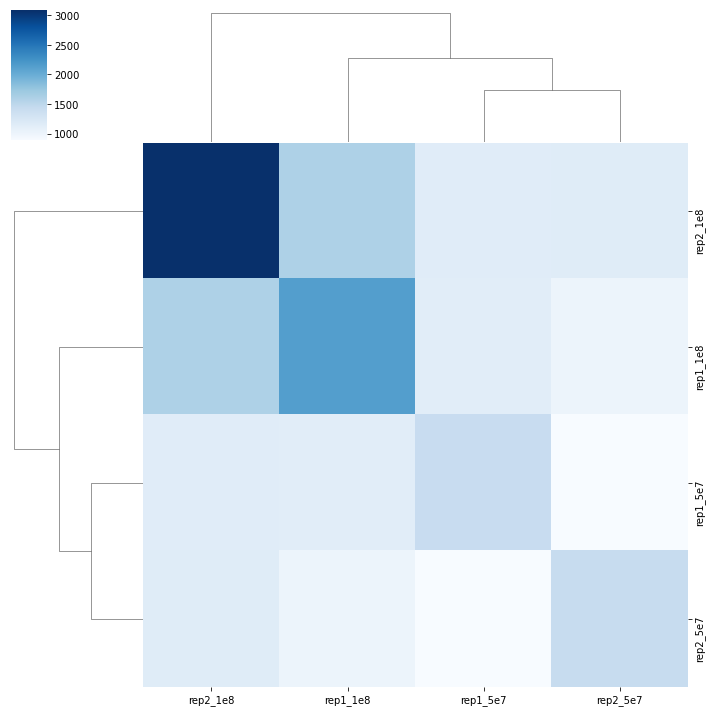

In [9]:
peptide_overlap = exps.compute_peptide_overlap_matrix() 
fig=plot_overlap_heatmap(peptide_overlap,plotting_kwargs={"cmap":"Blues","annot_kws":{"size": 24}})

### protein level overlap 

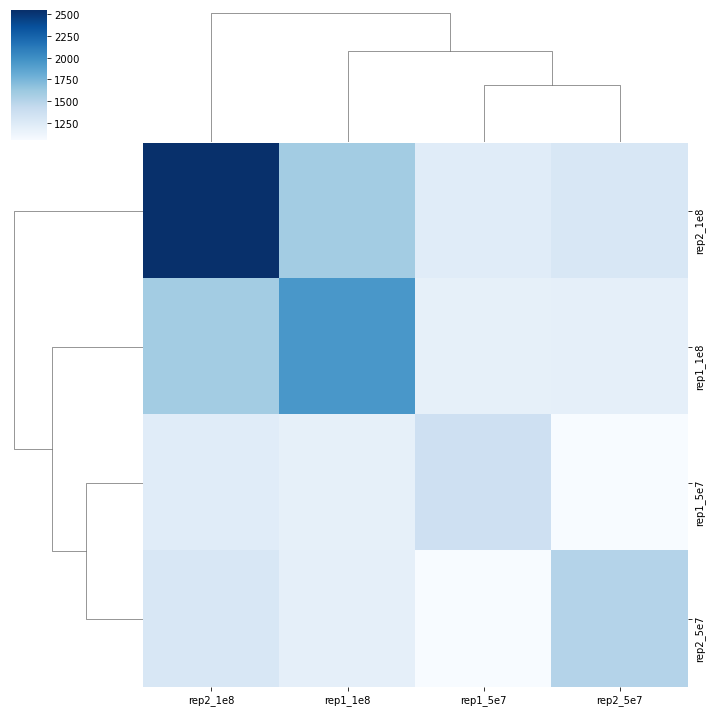

In [7]:
peptide_overlap = exps.compute_protein_overlap_matrix() 
fig=plot_overlap_heatmap(peptide_overlap,plotting_kwargs={"cmap":"Blues","annot_kws":{"size": 24}})

### Immunopeptidomic coverage and multidimensional scaling (MDS) plots

[MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) is a way to express similarity between objects in a dataset using pairwise distance. IPTK uses Immunopeptidomic coverage, introduced in the manuscript, to compute the pairwise between each pair of experiments. Hence similar experiments cluster together and dissimilar experiments are far away from each other. 

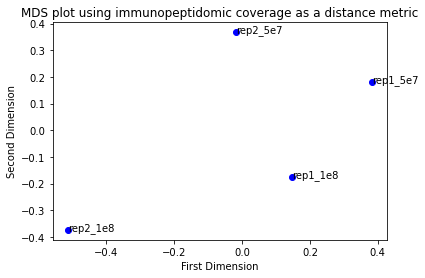

In [8]:
# First, compute the distance between each pair of experiments. 
ic_distance=compute_ic_distance_experiments(exps) # this might take a couple of minutes to run 
fig=plot_MDS_from_ic_coverage(ic_distance) # plot the results, 
## Note:
#------------
# due to the stochastic nature of the MDS function, the figure might look slightly different each time. 
#-------------

### Compute peptide representation over the set 

Let's try to get an idea about the number of times a peptides was observed over the experiment set, 
the number of times peptides where observed over all the experiments in the experiment set. 

In [11]:
peptide_counts = exps.compute_peptide_representation_count()

#### Let's visualize the peptide counts  

Text(0, 0.5, 'Counts')

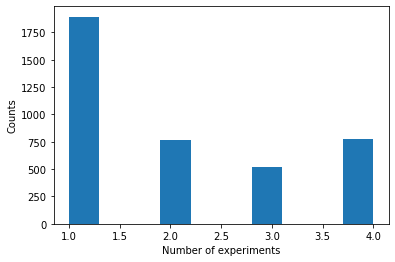

In [12]:
counts=[val for key, val in peptide_counts.items()]
## Compute a histogram of the results 
plt.hist(counts) 
plt.xlabel('Number of experiments')
plt.ylabel('Counts')

Number of proteins that was observed among different experiments

Here, we are going to visualize the number of proteins that were observed in one experiments, i.e. they are only obserrved in one experiment in the set of experiments, in two experiments, in three experiments, et cetra. 

In [23]:
protein_counts = exps.compute_protein_representation_count() 

Text(0, 0.5, 'Number of proteins.')

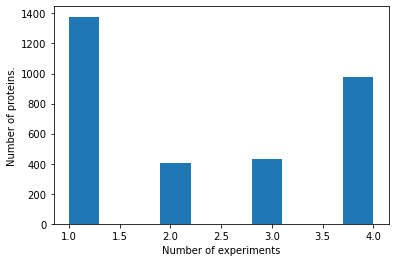

In [25]:
counts=[val for key, val in protein_counts.items()]
## Compute a histogram of the results 
plt.hist(counts) 
plt.xlabel('Number of experiments')
plt.ylabel('Number of proteins.')

### The coverage of proteins computed over the entire experiment set 

In [26]:
### Let's look at the coverage over the entire set 
coverage_entire_set = exps.compute_protein_coverage_over_the_set() # This might take a couple of minutes 

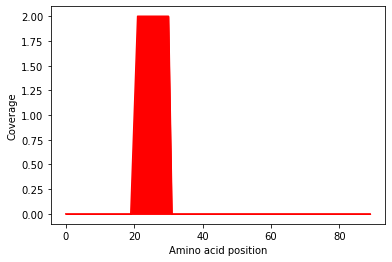

In [33]:
### Let's visualize the coverage of one random protein, A0A2R8Y8A0 
fig=plot_protein_coverage(coverage_entire_set['A0A2R8Y8A0'])

### Comparing the coverage between two experiments 

In [34]:
# First, let's get the proteins that are inferred in all experiemnts. 
all_proteins = exps.get_proteins_present_in_all()

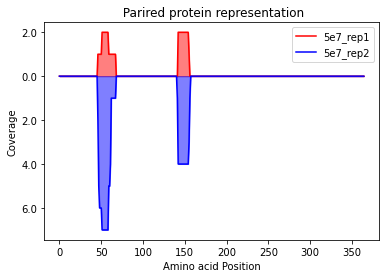

In [42]:
# Second, let's plot the pair representation of the protein, 
fig=plot_paired_represention(protein_one_repr={'5e7_rep1':exp_rep1_5e7.get_mapped_protein('Q5SUL5')},
                         protein_two_repr={'5e7_rep2':exp_rep2_5e7.get_mapped_protein('Q5SUL5')})

### Exporting the results 

Next, let's assume that we are interested in a more indepth downstream analysis of the peptides that are defined in all the experiments in the set. This can be done as follow,  

In [21]:
peptides_present_in_all = exps.get_peptides_present_in_all() 

In [55]:
print(f'Number of peptides defined in all experiments is: {len(peptides_present_in_all)}')

Number of peptides defined in all experiments is: 776


We can then export the results as fasta file as follows: 

In [43]:
write_auto_named_peptide_to_fasta(peptides_present_in_all,'peptides_present_in_all.fasta')